# Load GPU

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
#from skimage.io import imread #read images from files
import os
import cv2 as cv
from PIL import Image
from keras_unet_collection import models
import matplotlib.pyplot as plt # plt show image
import matplotlib.image as mpimg # mpimg read image
import tensorflow as tf

# Preparation of path_parasite_life_stage_classification

In [3]:
    path_parasite_life_stage_classification = 'E:/ziheng-projects/test_jerome/segmentation/data/aLatest/validation4_new/zz_test_manual/new/111_img/'

# Data preparation

In [4]:
from keras.utils import np_utils
base_tile_dir4 = path_parasite_life_stage_classification + 'red/' #path of the red class
df4= pd.DataFrame({'path': glob(os.path.join(base_tile_dir4,'*.png'))})
#df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
df4['filename'] = df4.path.map(lambda x: x.split('\\')[1])
df4['label']=0

base_tile_dir5 = path_parasite_life_stage_classification + 'white/' #path of the white class
df5= pd.DataFrame({'path': glob(os.path.join(base_tile_dir5,'*.png'))})
#df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
df5['filename'] = df5.path.map(lambda x: x.split('\\')[1])
df5['label']=1


base_tile_dir6 = path_parasite_life_stage_classification + 'yellow/' #path of the yellow class
df6= pd.DataFrame({'path': glob(os.path.join(base_tile_dir6,'*.png'))})
#df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
df6['filename'] = df6.path.map(lambda x: x.split('\\')[1])
df6['label']=2

base_tile_dir7 = path_parasite_life_stage_classification + 'blue/' #path of the blue class
df7= pd.DataFrame({'path': glob(os.path.join(base_tile_dir7,'*.png'))})
#df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
df7['filename'] = df7.path.map(lambda x: x.split('\\')[1])
df7['label']=3

df_val = pd.concat([df4,df5,df6,df7], ignore_index=True).reset_index()
df_val = df_val[["path", "filename", "label"]]

df_val['image'] = df_val['path'].map(cv.imread)


val_tensors = np.stack(list(df_val.image), axis = 0)
print(val_tensors.shape)
val_targets = np_utils.to_categorical(df_val.label, num_classes=4)

(444, 224, 224, 3)


# Preparation of model

In [5]:
from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Embedding
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def ViT_MLP(X, filter_num, activation='GELU', name='MLP'):
    '''
    The MLP block of ViT.
    
    ----------
    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, 
    T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. 
    An image is worth 16x16 words: Transformers for image recognition at scale. 
    arXiv preprint arXiv:2010.11929.
    
    Input
    ----------
        X: the input tensor of MLP, i.e., after MSA and skip connections
        filter_num: a list that defines the number of nodes for each MLP layer.
                        For the last MLP layer, its number of node must equal to the dimension of key.
        activation: activation of MLP nodes.
        name: prefix of the created keras layers.
        
    Output
    ----------
        V: output tensor.
    '''
    activation_func = eval(activation)
    
    for i, f in enumerate(filter_num):
        X = Dense(f, name='{}_dense_{}'.format(name, i))(X)
        X = activation_func(name='{}_activation_{}'.format(name, i))(X)
        
    return X

def ViT_block(V, num_heads, key_dim, filter_num_MLP, activation='GELU', name='ViT'):
    '''
    
    Vision transformer (ViT) block.
    
    ViT_block(V, num_heads, key_dim, filter_num_MLP, activation='GELU', name='ViT')
    
    ----------
    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, 
    T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. 
    An image is worth 16x16 words: Transformers for image recognition at scale. 
    arXiv preprint arXiv:2010.11929.
    
    Input
    ----------
        V: embedded input features.
        num_heads: number of attention heads.
        key_dim: dimension of the attention key (equals to the embeded dimensions).
        filter_num_MLP: a list that defines the number of nodes for each MLP layer.
                        For the last MLP layer, its number of node must equal to the dimension of key.
        activation: activation of MLP nodes.
        name: prefix of the created keras layers.
        
    Output
    ----------
        V: output tensor.
    
    '''
    # Multiheaded self-attention (MSA)
    V_atten = V # <--- skip
    V_atten = LayerNormalization(name='{}_layer_norm_1'.format(name))(V_atten)
    V_atten = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, 
                                 name='{}_atten'.format(name))(V_atten, V_atten)
    # Skip connection
    V_add = add([V_atten, V], name='{}_skip_1'.format(name)) # <--- skip
    
    # MLP
    V_MLP = V_add # <--- skip
    V_MLP = LayerNormalization(name='{}_layer_norm_2'.format(name))(V_MLP)
    V_MLP = ViT_MLP(V_MLP, filter_num_MLP, activation, name='{}_mlp'.format(name))
    # Skip connection
    V_out = add([V_MLP, V_add], name='{}_skip_2'.format(name)) # <--- skip
    
    return V_out

# Model definition

In [6]:
input_shape = (224, 224, 3)
img_input = Input(shape=input_shape)

# Block 1
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)



patch_size=1
x = patch_extract((patch_size, patch_size))(x)
x = patch_embedding(49, 128)(x)
filter_num_MLP = [32, 128]
num_transformer=6
name='TransLightNet'
for i in range(num_transformer):
    x = ViT_block(x, 12, 128, filter_num_MLP, activation='GELU',
                 name='{}_ViT_{}'.format(name, i))
x = Flatten()(x)  
x = Dense(256, activation='elu', name='fc1')(x)  
x = Dropout(0.5)(x) 



predictions = Dense(4, activation='softmax', name='predictions')(x) 
model = Model(img_input, predictions)  
model.compile(Adam(0.0001), loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 16) 2320        block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 16) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [7]:
#Download model 'Parasite life stage classification.hdf5' and put it inside the path_parasite_life_stage_classification 
model.load_weights(path_parasite_life_stage_classification + 'Parasite life stage classification.hdf5')
model.evaluate(val_tensors, val_targets)

14/14 [==============================] - 8s 86ms/step - loss: 0.1696 - accuracy: 0.9550


[0.16962604224681854, 0.954954981803894]

# Confusion metrix

[[108   0   3   0]
 [  0 103   6   2]
 [  2   6 103   0]
 [  0   0   1 110]]


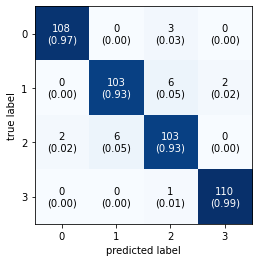

Accuracy_score: 0.955
Precision_score: 0.955
Recall: 0.955
F1_score: 0.955


In [8]:
#class label 0
base_tile_dir = base_tile_dir4
test_df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.png'))})
test_df['filename'] = test_df.path.map(lambda x: x.split('\\')[1])
test_df.head(5)

test_df['image'] = test_df['path'].map(cv.imread)
test_images = np.stack(test_df.image, axis = 0)
test_images.shape

predicted_labels0 =  [model.predict(np.expand_dims(tensor, axis=0))[0].argsort()[-1] for tensor in test_images]

y_true0 = [0 for i in range(111)]
##########################################
#class label 1
base_tile_dir = base_tile_dir5
test_df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.png'))})
test_df['filename'] = test_df.path.map(lambda x: x.split('\\')[1])
test_df.head(5)

test_df['image'] = test_df['path'].map(cv.imread)
test_images = np.stack(test_df.image, axis = 0)
test_images.shape

predicted_labels1 =  [model.predict(np.expand_dims(tensor, axis=0))[0].argsort()[-1] for tensor in test_images]
y_true1 = [1 for i in range(111)]
##########################################
#class label 2
base_tile_dir = base_tile_dir6
test_df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.png'))})
test_df['filename'] = test_df.path.map(lambda x: x.split('\\')[1])
test_df.head(5)

test_df['image'] = test_df['path'].map(cv.imread)
test_images = np.stack(test_df.image, axis = 0)
test_images.shape

predicted_labels2 =  [model.predict(np.expand_dims(tensor, axis=0))[0].argsort()[-1] for tensor in test_images]
y_true2 = [2 for i in range(111)]
##########################################
#class label 3
base_tile_dir = base_tile_dir7
test_df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.png'))})
test_df['filename'] = test_df.path.map(lambda x: x.split('\\')[1])
test_df.head(5)

test_df['image'] = test_df['path'].map(cv.imread)
test_images = np.stack(test_df.image, axis = 0)
#test_images = np.reshape(test_images,test_images.shape+(1,))
test_images.shape

predicted_labels3 =  [model.predict(np.expand_dims(tensor, axis=0))[0].argsort()[-1] for tensor in test_images]
y_true3 = [3 for i in range(111)]

###############################################################################################################

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#from glob import glob 
y_true=y_true0+y_true1+y_true2+y_true3
y_pred=predicted_labels0+predicted_labels1+predicted_labels2+predicted_labels3
multiclass=confusion_matrix(y_true, y_pred)
print(multiclass)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=multiclass, show_absolute=True,  show_normed=True)
plt.show()

#accuracy_score, precision_score, recall_score, f1_score, 
print('Accuracy_score: %.3f' % accuracy_score(y_true, y_pred))
print('Precision_score: %.3f' % precision_score(y_true, y_pred,average='weighted'))
print('Recall: %.3f' % recall_score(y_true, y_pred,average='weighted'))
print('F1_score: %.3f' % f1_score(y_true, y_pred,average='weighted'))